In [1]:
!pip install torchfile

  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchfile


['coco-data', 'models', 'coco-train-val2017']
2022_12_11_22_23_07
tmp/
checking...
Load filenames from: ../input/coco-data/coco/coco/train/filenames.pickle (82783)
82783
../input/coco-train-val2017/train2014/train2014
82783
COCO_train2014_000000263229
COCO_train2014_000000487025
te:  82783
embedding....
STAGE1_G(
  (ca_net): CA_NET(
    (fc): Linear(in_features=1024, out_features=256, bias=True)
    (relu): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=228, out_features=24576, bias=False)
    (1): BatchNorm1d(24576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (upsample1): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(1536, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
  )
  (upsample2): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:746: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


data: --  [tensor([[[[-0.6392, -0.7647, -0.8353,  ..., -0.5608, -0.6078, -0.3098],
          [-0.6078, -0.7725, -0.6863,  ..., -0.3412, -0.2235,  0.0118],
          [-0.6314, -0.7490, -0.5686,  ..., -0.2078, -0.0902,  0.0039],
          ...,
          [-0.1294, -0.1137, -0.1294,  ...,  0.0353,  0.0275,  0.0510],
          [-0.2471, -0.2471, -0.3255,  ...,  0.0353,  0.0431,  0.0510],
          [-0.1137, -0.1686, -0.2157,  ...,  0.0431,  0.0431,  0.0431]],

         [[-0.8353, -0.8196, -0.7882,  ..., -0.5137, -0.5843, -0.2784],
          [-0.8353, -0.8510, -0.8275,  ..., -0.2941, -0.1686,  0.0902],
          [-0.8431, -0.8510, -0.8275,  ..., -0.1216, -0.0039,  0.0980],
          ...,
          [-0.1373, -0.1137, -0.1373,  ..., -0.0196, -0.0196, -0.0118],
          [-0.2471, -0.2471, -0.3176,  ...,  0.0039, -0.0039,  0.0039],
          [-0.1137, -0.1686, -0.2157,  ...,  0.0039, -0.0039,  0.0039]],

         [[-0.7725, -0.7490, -0.6941,  ..., -0.5216, -0.6235, -0.3098],
          [-0.7882,

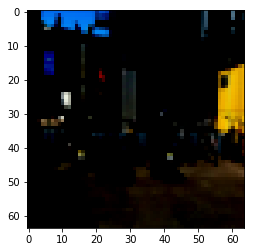

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from __future__ import print_function

from tensorboard import summary
from six.moves import range
from PIL import Image

from torch.autograd import Variable

from copy import deepcopy
from torch.nn import init

#!pip install torchfile

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# ------------------------------------------------  dataset.py --------------------------------------------------

import torch.utils.data as data
from PIL import Image
import PIL
import os
import os.path
import pickle
import random
import numpy as np
import pandas as pd

class TextDataset(data.Dataset):
    def __init__(self, data_dir, split='train', embedding_type='cnn-rnn',
                 imsize=64, transform=None, target_transform=None):

        self.transform = transform
        self.target_transform = target_transform
        self.imsize = imsize
        self.data = []
        self.data_dir = data_dir
        if data_dir.find('birds') != -1:
            self.bbox = self.load_bbox()
        else:
            print('checking...')
            self.bbox = None
        split_dir = os.path.join(data_dir, split)

        self.filenames = self.load_filenames(split_dir)
        self.embeddings = self.load_embedding(split_dir, embedding_type)
        #self.class_id = self.load_class_id(split_dir, len(self.filenames))
        # self.captions = self.load_all_captions()

    def get_img(self, img_path, bbox):
        img = Image.open(img_path).convert('RGB')
        width, height = img.size
        if bbox is not None:
            R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - R)
            y2 = np.minimum(height, center_y + R)
            x1 = np.maximum(0, center_x - R)
            x2 = np.minimum(width, center_x + R)
            img = img.crop([x1, y1, x2, y2])
        load_size = int(self.imsize * 76 / 64)
        img = img.resize((load_size, load_size), PIL.Image.BILINEAR)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def load_bbox(self):
        data_dir = self.data_dir
        bbox_path = os.path.join(data_dir, 'CUB_200_2011/bounding_boxes.txt')
        df_bounding_boxes = pd.read_csv(bbox_path,
                                        delim_whitespace=True,
                                        header=None).astype(int)
        #
        filepath = os.path.join(data_dir, 'CUB_200_2011/images.txt')
        df_filenames = \
            pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = df_filenames[1].tolist()
        print('Total filenames: ', len(filenames), filenames[0])
        #
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        for i in xrange(0, numImgs):
            # bbox = [x-left, y-top, width, height]
            bbox = df_bounding_boxes.iloc[i][1:].tolist()

            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        #
        return filename_bbox

    def load_all_captions(self):
        caption_dict = {}
        for key in self.filenames:
            caption_name = '%s/text/%s.txt' % (self.data_dir, key)
            captions = self.load_captions(caption_name)
            caption_dict[key] = captions
        return caption_dict

    def load_captions(self, caption_name):
        cap_path = caption_name
        with open(cap_path, "r") as f:
            captions = f.read().decode('utf8').split('\n')
        captions = [cap.replace("\ufffd\ufffd", " ")
                    for cap in captions if len(cap) > 0]
        return captions

    def load_embedding(self, data_dir, embedding_type):
        if embedding_type == 'cnn-rnn':
            print('embedding....')
            embedding_filename = os.path.join(data_dir, 'char-CNN-RNN-embeddings.pickle')
            #print(embedding_filename)
            #embedding_filename = '/char-CNN-RNN-embeddings.pickle'
        elif embedding_type == 'cnn-gru':
            embedding_filename = '/char-CNN-GRU-embeddings.pickle'
        elif embedding_type == 'skip-thought':
            embedding_filename = '/skip-thought-embeddings.pickle'

        with open(embedding_filename, 'rb') as f:
            #embeddings = pickle.load(f)
            embeddings = pickle._Unpickler(f)
            embeddings.encoding = 'latin1'
            embeddings = embeddings.load()
            #print(embeddings)
            embeddings = np.array(embeddings)
            # embedding_shape = [embeddings.shape[-1]]
        '''with open('mnist.pkl', 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            p = u.load()'''
            #print('embeddings: ', embeddings.shape)
        return embeddings

    '''def load_class_id(self, data_dir, total_num):
        if os.path.isfile(data_dir + '/class_info.pickle'):
            with open(data_dir + '/class_info.pickle', 'rb') as f:
                class_id = pickle.load(f)
        else:
            class_id = np.arange(total_num)
        return class_id'''
    

    def load_filenames(self, data_dir):
        #../input/coco-data/coco/coco/train/filenames.pickle
        filepath = os.path.join(data_dir, 'filenames.pickle')
        with open(filepath, 'rb') as f:
            filenames = pickle.load(f)
        print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        print(len(filenames))
        print(args.IMG_DIR)
        l=os.listdir('../input/coco-train-val2017/train2014/train2014')
        im_file=[x.split('.')[0] for x in l]
        #im_file = ['.'.join(x.split('.')[:-1]) for x in os.listdir("args.IMG_DIR") if os.path.isfile(os.path.join('args.IMG_DIR', x))]
        print(len(im_file))
        #str = 'COCO_train2014_'
        #im_file = [str + x for x in im_file]
        print(im_file[0]) 
        print(filenames[0]) #COCO_train2014_
        te = list(set(im_file) & set(filenames)) 
        print('te: ', len(te))
        #list_ = ['.'.join(x.split('.')[:-1]) for x in os.listdir("path/to/Data") if os.path.isfile(os.path.join('path/to/Data', x))]
        #print(ssd)
        return filenames

    
    '''def load_filenames(self, data_dir):
        #../input/coco-data/coco/coco/train/filenames.pickle
        filepath = os.path.join(data_dir, 'filenames.pickle')
        with open(filepath, 'rb') as f:
            filenames = pickle.load(f)
        print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        return filenames'''

    def __getitem__(self, index):
        key = self.filenames[index]
        # cls_id = self.class_id[index]
        #
        if self.bbox is not None:
            bbox = self.bbox[key]
            data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
            data_dir = self.data_dir

        # captions = self.captions[key]
        embeddings = self.embeddings[index, :, :]
        #print(args.IMG_DIR)
        #print(key)
        #y = key[-12:]
        img_name = '%s/%s.jpg' % (args.IMG_DIR, key)
        #img_name = '%s/images/%s.jpg' % (data_dir, key)
        img = self.get_img(img_name, bbox)

        embedding_ix = random.randint(0, embeddings.shape[0]-1)
        embedding = embeddings[embedding_ix, :]
        if self.target_transform is not None:
            embedding = self.target_transform(embedding)
        return img, embedding

    def __len__(self):
        return len(self.filenames)

# ------------------------------------------------  utils.py --------------------------------------------------

import os
import errno
import numpy as np
import torch
import torch.nn as nn
import torchvision.utils as vutils

#############################
def KL_loss(mu, logvar):
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return KLD


def compute_discriminator_loss(netD, real_imgs, fake_imgs,
                               real_labels, fake_labels,
                               conditions, gpus):
    criterion = nn.BCELoss()
    batch_size = real_imgs.size(0)
    cond = conditions.detach()
    fake = fake_imgs.detach()
    real_features = nn.parallel.data_parallel(netD, (real_imgs), gpus)
    fake_features = nn.parallel.data_parallel(netD, (fake), gpus)
    # real pairs
    inputs = (real_features, cond)
    real_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    errD_real = criterion(real_logits, real_labels)
    # wrong pairs
    inputs = (real_features[:(batch_size-1)], cond[1:])
    wrong_logits = \
        nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    errD_wrong = criterion(wrong_logits, fake_labels[1:])
    # fake pairs
    inputs = (fake_features, cond)
    fake_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    errD_fake = criterion(fake_logits, fake_labels)

    if netD.get_uncond_logits is not None:
        real_logits = nn.parallel.data_parallel(netD.get_uncond_logits, (real_features), gpus)
        fake_logits = nn.parallel.data_parallel(netD.get_uncond_logits, (fake_features), gpus)
        uncond_errD_real = criterion(real_logits, real_labels)
        uncond_errD_fake = criterion(fake_logits, fake_labels)
        #
        errD = ((errD_real + uncond_errD_real) / 2. + (errD_fake + errD_wrong + uncond_errD_fake) / 3.)
        errD_real = (errD_real + uncond_errD_real) / 2.
        errD_fake = (errD_fake + uncond_errD_fake) / 2.
    else:
        errD = errD_real + (errD_fake + errD_wrong) * 0.5
    return errD, errD_real.data, errD_wrong.data, errD_fake.data


def compute_generator_loss(netD, fake_imgs, real_labels, conditions, gpus):
    criterion = nn.BCELoss()
    cond = conditions.detach()
    fake_features = nn.parallel.data_parallel(netD, (fake_imgs), gpus)
    # fake pairs
    inputs = (fake_features, cond)
    fake_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    errD_fake = criterion(fake_logits, real_labels)
    if netD.get_uncond_logits is not None:
        fake_logits = \
            nn.parallel.data_parallel(netD.get_uncond_logits,
                                      (fake_features), gpus)
        uncond_errD_fake = criterion(fake_logits, real_labels)
        errD_fake += uncond_errD_fake
    return errD_fake


#############################
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


#############################
def save_img_results(data_img, fake, epoch, image_dir):
    num = args.VIS_COUNT
    fake = fake[0:num]
    # data_img is changed to [0,1]
    if data_img is not None:
        data_img = data_img[0:num]
        vutils.save_image(data_img, '%s/real_samples.png' % image_dir, normalize=True)
        # fake.data is still [-1, 1]
        vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % (image_dir, epoch), normalize=True)
    else:
        vutils.save_image(fake.data, '%s/lr_fake_samples_epoch_%03d.png' % (image_dir, epoch), normalize=True)


def save_model(netG, netD, epoch, model_dir):
    torch.save(
        netG.state_dict(),
        '%s/netG_epoch_%d.pth' % (model_dir, epoch))
    torch.save(
        netD.state_dict(),
        '%s/netD_epoch_last.pth' % (model_dir))
    print('Save G/D models')


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

# ------------------------------------------------  model.py --------------------------------------------------

import torch
import torch.nn as nn
import torch.nn.parallel
from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(True))
    return block


class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num),
            nn.ReLU(True),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out
class CA_NET(nn.Module):
    # some code is modified from vae examples
    # (https://github.com/pytorch/examples/blob/master/vae/main.py)
    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = args.DIMENSION
        self.c_dim = args.CONDITION_DIM
        self.fc = nn.Linear(self.t_dim, self.c_dim * 2, bias=True)
        self.relu = nn.ReLU()

    def encode(self, text_embedding):
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :self.c_dim]
        logvar = x[:, self.c_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if args.CUDA:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, text_embedding):
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar

class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf, nef, bcondition=True):
        super(D_GET_LOGITS, self).__init__()
        self.df_dim = ndf
        self.ef_dim = nef
        self.bcondition = bcondition
        if bcondition:
            self.outlogits = nn.Sequential(
                conv3x3(ndf * 8 + nef, ndf * 8),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())
        else:
            self.outlogits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())

    def forward(self, h_code, c_code=None):
        # conditioning output
        if self.bcondition and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((h_code, c_code), 1)
        else:
            h_c_code = h_code

        output = self.outlogits(h_c_code)
        return output.view(-1)


# ############# Networks for stageI GAN #############
class STAGE1_G(nn.Module):
    def __init__(self):
        super(STAGE1_G, self).__init__()
        self.gf_dim = args.GF_DIM * 8
        self.ef_dim = args.CONDITION_DIM
        self.z_dim = args.Z_DIM
        self.define_module()

    def define_module(self):
        ninput = self.z_dim + self.ef_dim
        ngf = self.gf_dim
        # TEXT.DIMENSION -> GAN.CONDITION_DIM
        self.ca_net = CA_NET()

        # -> ngf x 4 x 4
        self.fc = nn.Sequential(
            nn.Linear(ninput, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.ReLU(True))

        # ngf x 4 x 4 -> ngf/2 x 8 x 8
        self.upsample1 = upBlock(ngf, ngf // 2)
        # -> ngf/4 x 16 x 16
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        # -> ngf/8 x 32 x 32
        self.upsample3 = upBlock(ngf // 4, ngf // 8)
        # -> ngf/16 x 64 x 64
        self.upsample4 = upBlock(ngf // 8, ngf // 16)
        # -> 3 x 64 x 64
        self.img = nn.Sequential(
            conv3x3(ngf // 16, 3),
            nn.Tanh())

    def forward(self, text_embedding, noise):
        c_code, mu, logvar = self.ca_net(text_embedding)
        z_c_code = torch.cat((noise, c_code), 1)
        h_code = self.fc(z_c_code)

        h_code = h_code.view(-1, self.gf_dim, 4, 4)
        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)
        # state size 3 x 64 x 64
        fake_img = self.img(h_code)
        return None, fake_img, mu, logvar


class STAGE1_D(nn.Module):
    def __init__(self):
        super(STAGE1_D, self).__init__()
        self.df_dim = args.DF_DIM
        self.ef_dim = args.CONDITION_DIM
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # state size (ndf * 8) x 4 x 4)
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.get_cond_logits = D_GET_LOGITS(ndf, nef)
        self.get_uncond_logits = None

    def forward(self, image):
        img_embedding = self.encode_img(image)

        return img_embedding


# ############# Networks for stageII GAN #############
class STAGE2_G(nn.Module):
    def __init__(self, STAGE1_G):
        super(STAGE2_G, self).__init__()
        self.gf_dim = args.GF_DIM
        self.ef_dim = args.CONDITION_DIM
        self.z_dim = args.Z_DIM
        self.STAGE1_G = STAGE1_G
        # fix parameters of stageI GAN
        for param in self.STAGE1_G.parameters():
            param.requires_grad = False
        self.define_module()

    def _make_layer(self, block, channel_num):
        layers = []
        for i in range(args.R_NUM):
            layers.append(block(channel_num))
        return nn.Sequential(*layers)

    def define_module(self):
        ngf = self.gf_dim
        # TEXT.DIMENSION -> GAN.CONDITION_DIM
        self.ca_net = CA_NET()
        # --> 4ngf x 16 x 16
        self.encoder = nn.Sequential(
            conv3x3(3, ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.hr_joint = nn.Sequential(
            conv3x3(self.ef_dim + ngf * 4, ngf * 4),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.residual = self._make_layer(ResBlock, ngf * 4)
        # --> 2ngf x 32 x 32
        self.upsample1 = upBlock(ngf * 4, ngf * 2)
        # --> ngf x 64 x 64
        self.upsample2 = upBlock(ngf * 2, ngf)
        # --> ngf // 2 x 128 x 128
        self.upsample3 = upBlock(ngf, ngf // 2)
        # --> ngf // 4 x 256 x 256
        self.upsample4 = upBlock(ngf // 2, ngf // 4)
        # --> 3 x 256 x 256
        self.img = nn.Sequential(
            conv3x3(ngf // 4, 3),
            nn.Tanh())

    def forward(self, text_embedding, noise):
        _, stage1_img, _, _ = self.STAGE1_G(text_embedding, noise)
        stage1_img = stage1_img.detach()
        encoded_img = self.encoder(stage1_img)

        c_code, mu, logvar = self.ca_net(text_embedding)
        c_code = c_code.view(-1, self.ef_dim, 1, 1)
        c_code = c_code.repeat(1, 1, 16, 16)
        i_c_code = torch.cat([encoded_img, c_code], 1)
        h_code = self.hr_joint(i_c_code)
        h_code = self.residual(h_code)

        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)

        fake_img = self.img(h_code)
        return stage1_img, fake_img, mu, logvar


class STAGE2_D(nn.Module):
    def __init__(self):
        super(STAGE2_D, self).__init__()
        self.df_dim = args.DF_DIM
        self.ef_dim = args.CONDITION_DIM
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),  # 128 * 128 * ndf
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),  # 64 * 64 * ndf * 2
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),  # 32 * 32 * ndf * 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),  # 16 * 16 * ndf * 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),  # 8 * 8 * ndf * 16
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),  # 4 * 4 * ndf * 32
            conv3x3(ndf * 32, ndf * 16),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),   # 4 * 4 * ndf * 16
            conv3x3(ndf * 16, ndf * 8),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)   # 4 * 4 * ndf * 8
        )

        self.get_cond_logits = D_GET_LOGITS(ndf, nef, bcondition=True)
        self.get_uncond_logits = D_GET_LOGITS(ndf, nef, bcondition=False)

    def forward(self, image):
        img_embedding = self.encode_img(image)

        return img_embedding
    
# ------------------------------------------------  trainer.py --------------------------------------------------

import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import os
import time

import numpy as np
import torchfile

import matplotlib.pyplot as plt
from torchvision.utils import save_image

class GANTrainer(object):
    def __init__(self, output_dir):
        if args.FLAG:
            self.model_dir = os.path.join(output_dir, 'Model')
            self.image_dir = os.path.join(output_dir, 'Image')
            self.log_dir = os.path.join(output_dir, 'Log')
            mkdir_p(self.model_dir)
            mkdir_p(self.image_dir)
            mkdir_p(self.log_dir)
            #self.summary_writer = FileWriter(self.log_dir)

        self.max_epoch = args.MAX_EPOCH
        self.snapshot_interval = args.SNAPSHOT_INTERVAL

        s_gpus = args.GPU_ID.split(',')
        self.gpus = [int(ix) for ix in s_gpus]
        self.num_gpus = len(self.gpus)
        self.batch_size = args.BATCH_SIZE * self.num_gpus
        self.output_dir = output_dir
        #print(self.gpus[0])
        #torch.cuda.set_device(self.gpus[0])
        cudnn.benchmark = True
        
        # ############# For training stageI GAN #############
    def load_network_stageI(self):
        #from model import STAGE1_G, STAGE1_D
        netG = STAGE1_G()
        netG.apply(weights_init)
        print(netG)
        netD = STAGE1_D()
        netD.apply(weights_init)
        print(netD)
        print('***********************************************************')

        if args.NET_G != '':
            #state_dict = torch.load(args.NET_G, map_location=lambda storage, loc: storage)
            #netG.load_state_dict(state_dict)
            print('generator 1')
            print('Load from: ', args.NET_G)
        if args.NET_D != '':
            #state_dict = torch.load(args.NET_D,map_location=lambda storage, loc: storage)
            #netD.load_state_dict(state_dict)
            print('discriminator 1')
            print('Load from: ', args.NET_D)
        if args.CUDA:
            netG.cuda()
            netD.cuda()
        return netG, netD
        
    def load_network_stageII(self):
        #from model import STAGE1_G, STAGE2_G, STAGE2_D

        Stage1_G = STAGE1_G()
        netG = STAGE2_G(Stage1_G)
        netG.apply(weights_init)
        #print(netG)
        if args.NET_G != '':
            #state_dict = torch.load(args.NET_G,map_location=lambda storage, loc: storage)
            #netG.load_state_dict(state_dict)
            print('Load from: ', args.NET_G)
        elif args.STAGE1_G != '':
            #state_dict = torch.load(args.STAGE1_G,map_location=lambda storage, loc: storage)
            #netG.STAGE1_G.load_state_dict(state_dict)
            print('Load from: ', args.STAGE1_G)
        else:
            print("Please give the Stage1_G path")
            return

        netD = STAGE2_D()
        netD.apply(weights_init)
        if args.NET_D != '':
            #state_dict = torch.load(args.NET_D,map_location=lambda storage, loc: storage)
            #netD.load_state_dict(state_dict)
            print('Load from: ', args.NET_D)
        #print(netD)

        if args.CUDA:
            netG.cuda()
            netD.cuda()
        return netG, netD
    
    def train(self, data_loader, stage=1):
        if stage == 1:
            netG, netD = self.load_network_stageI()
        else:
            netG, netD = self.load_network_stageII()

        nz = args.Z_DIM
        batch_size = self.batch_size
        noise = Variable(torch.FloatTensor(batch_size, nz))
        fixed_noise = Variable(torch.FloatTensor(batch_size, nz).normal_(0, 1),volatile=True)
        real_labels = Variable(torch.FloatTensor(batch_size).fill_(1))
        fake_labels = Variable(torch.FloatTensor(batch_size).fill_(0))
        if args.CUDA:
            noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
            real_labels, fake_labels = real_labels.cuda(), fake_labels.cuda()

        generator_lr = args.GENERATOR_LR
        discriminator_lr = args.DISCRIMINATOR_LR
        lr_decay_step = args.LR_DECAY_EPOCH
        optimizerD = optim.Adam(netD.parameters(), lr=args.DISCRIMINATOR_LR, betas=(0.5, 0.999))
        netG_para = []
        for p in netG.parameters():
            if p.requires_grad:
                netG_para.append(p)
        optimizerG = optim.Adam(netG_para,lr=args.GENERATOR_LR,betas=(0.5, 0.999))
        count = 0
        c = 0
        for epoch in range(self.max_epoch):
            if c == 1:
                break
            start_t = time.time()
            if epoch % lr_decay_step == 0 and epoch > 0:
                generator_lr *= 0.5
                for param_group in optimizerG.param_groups:
                    param_group['lr'] = generator_lr
                discriminator_lr *= 0.5
                for param_group in optimizerD.param_groups:
                    param_group['lr'] = discriminator_lr
            br = 0
            for i, data in enumerate(data_loader, 0):
                if br==3:
                    break
                ######################################################
                # (1) Prepare training data
                ######################################################
                print('data: -- ', data)
                print('---------------------')
                real_img_cpu, txt_embedding = data
                #print('embedding:  ', txt_embedding)
                real_imgs = Variable(real_img_cpu)
                txt_embedding = Variable(txt_embedding)
                #print('text_embedding:  ', txt_embedding)
                if args.CUDA:
                    real_imgs = real_imgs.cuda()
                    txt_embedding = txt_embedding.cuda()

                #######################################################
                # (2) Generate fake images
                ######################################################
                noise.data.normal_(0, 1)
                inputs = (txt_embedding, noise)
                _, fake_imgs, mu, logvar = \
                    nn.parallel.data_parallel(netG, inputs, self.gpus)

                ############################
                # (3) Update D network
                ###########################
                netD.zero_grad()
                errD, errD_real, errD_wrong, errD_fake = \
                    compute_discriminator_loss(netD, real_imgs, fake_imgs,
                                               real_labels, fake_labels,
                                               mu, self.gpus)
                errD.backward()
                optimizerD.step()
                ############################
                # (2) Update G network
                ###########################
                netG.zero_grad()
                errG = compute_generator_loss(netD, fake_imgs,
                                              real_labels, mu, self.gpus)
                kl_loss = KL_loss(mu, logvar)
                errG_total = errG + kl_loss * args.KL
                errG_total.backward()
                optimizerG.step()
                
                br = br+1
                
                count = count + 1
                if i % 10 == 0:
                    '''summary_D = summary.scalar('D_loss', errD.data)
                    summary_D_r = summary.scalar('D_loss_real', errD_real)
                    summary_D_w = summary.scalar('D_loss_wrong', errD_wrong)
                    summary_D_f = summary.scalar('D_loss_fake', errD_fake)
                    summary_G = summary.scalar('G_loss', errG.data)
                    summary_KL = summary.scalar('KL_loss', kl_loss.data)

                    self.summary_writer.add_summary(summary_D, count)
                    self.summary_writer.add_summary(summary_D_r, count)
                    self.summary_writer.add_summary(summary_D_w, count)
                    self.summary_writer.add_summary(summary_D_f, count)
                    self.summary_writer.add_summary(summary_G, count)
                    self.summary_writer.add_summary(summary_KL, count)'''

                    # save the image result for each epoch
                    inputs = (txt_embedding, fixed_noise)
                    lr_fake, fake, _, _ = nn.parallel.data_parallel(netG, inputs, self.gpus)
                    print('real_img_cpu', real_img_cpu.shape)   # real_img_cpu torch.Size([128, 3, 64, 64])
                    #print('text_embedding:  ', txt_embedding)
                    print(type(real_img_cpu))
                    print(real_img_cpu[0].shape)
                    plt.imshow(real_img_cpu[0].permute(1, 2, 0))
                    #plt.imshow(real_img_cpu[1].numpy().squeeze(), cmap='RGB')
                    #plt.imshow(real_img_cpu) 
                    '''save_img_results(real_img_cpu, fake, epoch, self.image_dir)
                    if lr_fake is not None:
                        save_img_results(None, lr_fake, epoch, self.image_dir)'''
                print('br', br)
            end_t = time.time()
            c = 1
            print('''[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f Loss_KL: %.4f
                     Loss_real: %.4f Loss_wrong:%.4f Loss_fake %.4f
                     Total Time: %.2fsec
                  '''
                  % (epoch, self.max_epoch, i, len(data_loader),
                     errD.data, errG.data, kl_loss.data,
                     errD_real, errD_wrong, errD_fake, (end_t - start_t)))
            if epoch % self.snapshot_interval == 0:
                save_model(netG, netD, epoch, self.model_dir)
        #
        #save_model(netG, netD, self.max_epoch, self.model_dir)
        #
        #self.summary_writer.close()'''
        
    


# ------------------------------------------------  main.py --------------------------------------------------

import torch.backends.cudnn as cudnn
import torch
import torchvision.transforms as transforms

import argparse
import os
import random
import sys
import pprint
import datetime
import dateutil
import dateutil.tz
import torchfile
    
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

if __name__ == '__main__':
    params = dict()
    # parameters
    parser = argparse.ArgumentParser()
    params = dict()
    params['CONFIG_NAME']='stageI'
    params['DATASET_NAME']='coco'
    params['EMBEDDING_TYPE']='cnn-rnn'
    params['GPU_ID']='0'
    params['CUDA']='TRUE'
    params['WORKERS']=4
    params['NET_G']=''
                    #../input/models/coco_netg_epoch_90/coco_netG_epoch_90.pth
    params['NET_D']=''
    #params['STAGE1_G']='../output/coco_stageI/Model/netG_epoch_120.pth'
    params['DATA_DIR']='../input/coco-data/coco/coco'
    params['IMG_DIR'] = '../input/coco-train-val2017/train2014/train2014'
    params['VIS_COUNT']=64
    params['Z_DIM']=100
    params['IMSIZE']=64
    params['STAGE']=1
    #TRAIN = edict()
    params['FLAG']='TRUE'
    params['BATCH_SIZE']=128
    params['MAX_EPOCH']=2
    params['SNAPSHOT_INTERVAL']=1
    #params['PRETAINED_MODEL']=''
    #params['PRETRAINED_EPOCH']=600
    params['LR_DECAY_EPOCH']=20
    params['DISCRIMINATOR_LR']=0.0002
    params['GENERATOR_LR']=0.0002
    params['KL']=2.0
    #gan
    params['CONDITION_DIM']=128
    params['DF_DIM']=96
    params['GF_DIM']=192
    #params['R_NUM']=2
    #text
    params['DIMENSION']=1024
    #params['manualSeed']=random.randint(1, 10000)
    args = Struct(**params) #Convert nested Python dict to object

   # s = Struct(**params)
   # config = s             # parser.parse_args()
   # print(config)
    manualSeed = random.randint(1, 10000)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)
    now = datetime.datetime.now(dateutil.tz.tzlocal())
    timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
    print(timestamp)
    
    output_dir = 'tmp/'
    #output_dir = '../output/%s_%s_%s' % (args.DATASET_NAME, args.CONFIG_NAME, timestamp)
    print(output_dir)
    num_gpu = len(args.GPU_ID.split(','))
    if args.FLAG:
        image_transform = transforms.Compose([
            transforms.RandomCrop(args.IMSIZE),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        dataset = TextDataset(args.DATA_DIR, 'train',
                              imsize=args.IMSIZE,
                              transform=image_transform)
        assert dataset
        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=args.BATCH_SIZE * num_gpu,
            drop_last=True, shuffle=True, num_workers=int(args.WORKERS))

        algo = GANTrainer(output_dir)
        algo.train(dataloader, args.STAGE)
        
#'../input/visda2018-validation/val2017/val2017/000000144280.jpg'
#'../input/visda2018-validation/val2017/val2017/000000212226.jpg